In [2]:
#importing required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import math
from sklearn.model_selection import KFold

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

from sklearn.manifold import TSNE

import learning_utils as lu
import random
import scipy.stats as st
import datetime

#format of figures

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

now=datetime.datetime.today()

C:\Users\User\AppData\Local\Temp\ipykernel_9880\2065449660.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seen_df['content'][ind] = seen_df['title'][ind] + " " + seen_df['content'][ind]+" " + seen_df['wosarticle__de'][ind] +" " + seen_df['wosarticle__wc'][ind]
C:\Users\User\AppData\Local\Temp\ipykernel_9880\2065449660.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_df['content'][ind] = str(unseen_df['title'][ind]) + " " + str(unseen_df['content'][ind])+" " + str(unseen_df['wosarticle__de'][ind]) +" " + str(unseen_df['wosarticle__wc'][ind])


seen_df = (407, 8)
unseen_df = (5713, 8)
df = (6120, 8)


Text(0, 0.5, 'Number of documents')

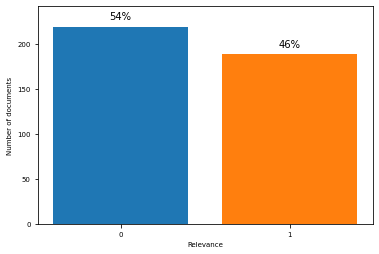

In [5]:
#importing databases

seen_df = pd.read_csv('seen_df.csv')
unseen_df=pd.read_csv('unseen_df.csv')

#defining the content, whether to include title and keywords, ,"title","keywords"

include = ["content","title", "keywords"]

def include_doc(include):
    
    if ("content" in include) and ("title" in include) and ("keywords" in include): 
        for ind in seen_df.index:
                seen_df['content'][ind] = seen_df['title'][ind] + " " + seen_df['content'][ind]+" " + seen_df['wosarticle__de'][ind] +" " + seen_df['wosarticle__wc'][ind]
        
        for ind in unseen_df.index:
                unseen_df['content'][ind] = str(unseen_df['title'][ind]) + " " + str(unseen_df['content'][ind])+" " + str(unseen_df['wosarticle__de'][ind]) +" " + str(unseen_df['wosarticle__wc'][ind])

    
    elif ("content" in include) and ("title" in include):
        for ind in seen_df.index:
                seen_df['content'][ind] = seen_df['title'][ind] + " " + seen_df['content'][ind]
        
        for ind in unseen_df.index:
                unseen_df['content'][ind] = str(unseen_df['title'][ind]) + " " + str(unseen_df['content'][ind])
                
    
    elif ("content" in include) and ("keywords" in include): 
        for ind in seen_df.index:
                seen_df['content'][ind] = seen_df['content'][ind]+" " + seen_df['wosarticle__de'][ind] +" " + seen_df['wosarticle__wc'][ind]
        
        for ind in unseen_df.index:
                unseen_df['content'][ind] = str(unseen_df['content'][ind])+" " + str(unseen_df['wosarticle__de'][ind]) +" " + str(unseen_df['wosarticle__wc'][ind])

    print ("seen_df =",seen_df.shape)
    print ("unseen_df =",unseen_df.shape)
    
    return
    
   
include_doc(include)         

#merging seen_df and unseen_df

df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print ("df =",df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

#loading and merging gudf

gudf=pd.read_csv('gudf.csv') 

df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
df.to_csv('dfall.csv', index=False)
#plotting relevent vs non-relevent

fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')


In [4]:
#vectorizing the texts

import pickle
import scipy
revectorize = True
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=lu.tokenize
    )
    vec.fit(df.loc[seen_index,'content'].astype(str))
    ab_X = vec.transform(df['content'].astype(str))
    with open ('vec.pickle','wb') as f: #changed dir from data/vec.pickle to just vec.pickle
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('X.npz', ab_X)
else:
    with open ('vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('X.npz')#changed dir from data/vec.pickle to just vec.pickle
    
print(ab_X.shape)


(6121, 3322)


In [5]:
#defining the training of models

def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None,
    upsample=False,roundup=False, df=None,
    stratified_k=False, test_index=None, p_threshold=None):    
    
    if stratified_k:
        label_encoder = LabelEncoder()
        kf = StratifiedKFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],label_encoder.fit_transform(y[seen_index]))
    else:
        kf = KFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],y[seen_index])
    i=0    
    
    def tpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[1]
    def fpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[0]
    def prec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[0]
    def rec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[1]    
    
    scores = [
        # name, function, on y when multiclas, on each y when multiclass, # proba
        ('p',precision_score, True, True, False),
        ('r',recall_score, True, True, False),
        ('f1', f1_score, True, True, False),
        ('e', accuracy_score, True, True, False),
        ('i', None, False, False, False),
        ('auc', roc_auc_score, True, True, True),
        ('tpr', tpr, False, True, True),
        ('fpr', fpr, False, True, True),
        ('prec', prec, False, True, True),
        ('rec', rec, False, True, True)
    ]    
    
    if classes:
        scores += [
            ('cov_err', coverage_error, True, False, False),
            ('LRAP', label_ranking_average_precision_score, True, False, False),
            ('LRL', label_ranking_loss, True, False, False)
        ]    
        
    for model in clf_models:
        for m in scores:
            model[m[0]] = []
        metrics = ['e']
        if classes:
            for j, y_class in enumerate(classes):
                for m in scores:
                    if m[1]:
                        model[f'{m[0]}\n{y_class}'] = []                
                        
                metrics += [f'p\n{y_class}', f'r\n{y_class}']    
                
    if test_index is not None:
        test_preds = []    
    for k_train, k_test in kfs:
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        if test_index is not None:
            k_test = test_index
        if upsample:
            ros = RandomOverSampler(random_state=42)
            if classes:
                lp = LabelPowerset()
                yt = lp.transform(y)
                X_train, y_resampled = ros.fit_resample(X[k_train],yt[k_train])
                y_train = lp.inverse_transform(y_resampled).todense()
            else:
                X_train, y_train = ros.fit_resample(X[k_train],y[k_train].todense())
        else:
            X_train = X[k_train]
            y_train = y[k_train]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X_train,y_train)
            predictions = clf.predict(X[k_test])
            try:
                predictions_proba = clf.predict_proba(X[k_test])
            except:
                predictions_proba = predictions
                print("WARNING! Can't predict probabilities with this model, just using binary predictions")
                
            if hasattr(predictions_proba,"todense"):
                predictions_proba = predictions_proba.todense()
            if hasattr(predictions,"todense"):
                predictions = predictions.todense()
            if test_index is not None:
                test_preds.append(predictions_proba)
            if p_threshold is not None:
                predictions = np.where(predictions_proba>=p_threshold,1,0)[:,1]           
            
            if classes:
                if roundup:
                    for j, c in enumerate(predictions_proba.argmax(axis=1)):
                        predictions[j,c] = 1
                for m in scores:
                    if m[4]:
                        y_pred = predictions_proba
                    else:
                        y_pred = predictions                    
                    if not m[1] or not m[2]:
                        continue
                    try:
                        model[m[0]].append(m[1](y[k_test],y_pred,average="weighted"))
                    except TypeError:
                        model[m[0]].append(m[1](y[k_test],y_pred))
                    except ValueError:
                        pass
                    
                for j, y_class in enumerate(classes):
                    # if y[k_train,i].sum() == 0:
                    #     print("no labels for {y_class}")
                    for m in scores:
                        if not m[1]:
                            continue
                        if m[3]: # if do this metric on each class
                            if m[4]: # if use probabilities
                                y_pred = predictions_proba
                            else:
                                y_pred = predictions
                            try:
                                model[f'{m[0]}\n{y_class}'].append(m[1](y[k_test,j],y_pred[:,j]))
                            except:
                                model[f'{m[0]}\n{y_class}'].append(None)
                    if df is not None:
                        df.loc[k_test,f"{y_class} - k_prediction"] = predictions_proba[:,j]
                        df.loc[k_test,f"{y_class} - k_prediction_binary"] = predictions[:,j]
            else:
                for m in scores:
                    if not m[1]:
                        continue
                    model[m[0]].append(m[1](y[k_test],predictions))
                if df is not None:
                    df.loc[k_test, "y_k_prediction"] = predictions_proba[:,1]    
                    
    if classes:
        if df is not None:
            return clf_models, metrics, df
        return clf_models, metrics
    else:
        if df is not None:
            return clf_models, df
        elif test_index is not None:
            return clf_models, np.array(test_preds)
        return clf_models

print ("Done")

Done


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from importlib import reload  
import learning_utils as lu



#NB: keep the preferred model last if you want to use the y_k prediction as it overwrites with every new model
models = [
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=2020
        )
    },
    {
        'title': 'Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    },
    {
        'title': 'RandForest',
        'model': RandomForestClassifier(n_estimators=1000, max_depth=None,
                                        max_features="sqrt", min_samples_split=2, random_state= 2020)
    },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, random_state= 2020)
    },
]

models, df = lu.cross_validate_models(ab_X, y, models, seen_index,df=df)

1
2
3
4
5
6
7
8
9
10


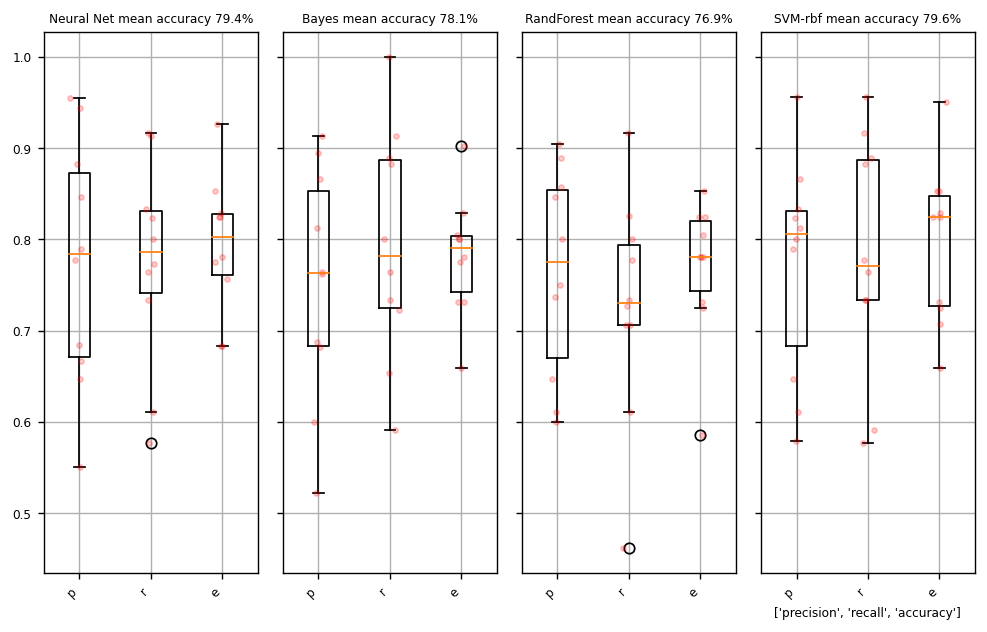

In [7]:
#fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)
fig, axs = plt.subplots(1, len(models),figsize=(8,5),dpi=125,sharey=True)
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['precision', 'recall', 'accuracy'])
#plt.show()

plt.savefig(f'Modelcomparison.png')
plt.show()

In [8]:
clf = SVC(kernel='rbf',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

976 out of 5713 documents are predicted to be relevant


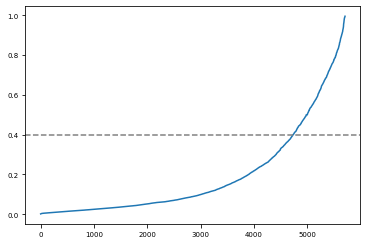

In [9]:
plt.close()

threshold = 0.4

df['0 - relevance - prediction'] = None
df.loc[unseen_index,'0 - relevance - prediction'] = y_pred[:,1]

predicted_index = df[df['0 - relevance - prediction']>threshold].index

fig, ax = plt.subplots()

pdf = df.sort_values('0 - relevance - prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['0 - relevance - prediction'])
ax.axhline(threshold,linestyle="--",color="grey")

rel = df[pdf['0 - relevance - prediction']>threshold].shape[0]
tot = pdf[pdf['0 - relevance - prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

#df[['id','0 - relevance - prediction']].to_csv(f'predictions_{now}.csv',index=False)#removed doctables/ from dir

plt.show()

In [10]:
RelevantDocs  = df[(df['0 - relevance - prediction'] >= threshold) | (df['relevant'] == 1)]

RelevantDocs.shape

(1159, 14)

In [11]:
outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
outdf = outdf[['id', 'relevant', '0 - relevance - prediction']]
outdf.columns = ['id', 'label', 'prediction']

outdf.to_csv('pred.csv', index=False)
outdf
RelevantDocs.to_csv('relv.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_14832\4249204894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdf.loc[outdf['seen'] ==0, 'relevant'] = None


In [12]:
df

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Analytical,1 - Empirical,1 - Hybrid,1 - ML,y_k_prediction,0 - relevance - prediction
0,21502,Strategies for Structural and Energy Improveme...,Strategies for Structural and Energy Improveme...,2021.0,unreinforced masonry buildings modern masonry...,VULNERABILITY RETROFITS SAVINGS MODEL,0,0,0.0,0.0,0.0,0.0,NaN,0.219052
1,17496,Evaluation of Building Type Adjacent Structure...,Evaluation of Building Type Adjacent Structure...,2015.0,Push-Over analysis scaled accelograms fragil...,None,0,0,0.0,0.0,0.0,0.0,NaN,0.542973
2,18572,Integration of Probabilistic and Multi-Hazard ...,Integration of Probabilistic and Multi-Hazard ...,2017.0,Emergency response Manizales (Colombia) Mult...,development project disaster management haza...,0,0,0.0,0.0,0.0,0.0,NaN,0.065839
3,20357,Seismic collapse fragility of low-rise steel m...,Seismic collapse fragility of low-rise steel m...,2021.0,Additive mass Seismic collapse Shaking table...,Disaster prevention Earthquakes Losses Nume...,0,0,0.0,0.0,0.0,0.0,NaN,0.224816
4,21002,Seismic risk analysis with reliability methods...,Seismic risk analysis with reliability methods...,2013.0,Seismic risk Probabilistic models Reliabilit...,None,0,0,0.0,0.0,0.0,0.0,NaN,0.293652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6116,15702,ASCE 31/41 evaluation of damaged chilean walle...,ASCE 31/41 evaluation of damaged chilean walle...,2013.0,None,Buildings Damage detection Codes and standar...,0,0,0.0,0.0,0.0,0.0,NaN,0.089722
6117,21170,Seismic vulnerability assessment of precast RC...,Seismic vulnerability assessment of precast RC...,2021.0,Damage index Fragility curves Incremental dy...,Concrete buildings Concrete construction Dam...,0,0,0.0,0.0,0.0,0.0,NaN,0.831522
6118,19576,Post-earthquake damage identification of an RC...,Post-earthquake damage identification of an RC...,2021.0,Structural health monitoring Gorkha earthquak...,None,0,0,0.0,0.0,0.0,0.0,0.058014,None
6119,12873,Empirical fragility curves of buildings in nor...,Empirical fragility curves of buildings in nor...,2016.0,Damage ratio indices Empirical fragility curv...,Earthquake engineering 2011 off the pacific c...,1,1,0.0,1.0,0.0,0.0,NaN,0.988573


In [13]:
df['categories'] = df['1 - Analytical'] + df['1 - Empirical'] + df['1 - Hybrid'] + df['1 - ML']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen Analytical documents:", df.loc[df['seen']==1,'1 - Analytical'].sum())
print("seen Empirical documents", df.loc[df['seen']==1,'1 - Empirical'].sum())
print("seen Hybrid documents", df.loc[df['seen']==1,'1 - Hybrid'].sum())
print("seen ML documents", df.loc[df['seen']==1,'1 - ML'].sum())
print("seen in multiple", df.loc[df['categories']>=2,].shape[0])
print("seen non relevant documents",df.loc[(df['seen']==1) & (df['categories']==0),].shape[0])

seen documents: 408
seen Analytical documents: 67.0
seen Empirical documents 47.0
seen Hybrid documents 30.0
seen ML documents 28.0
seen in multiple 0
seen non relevant documents 236


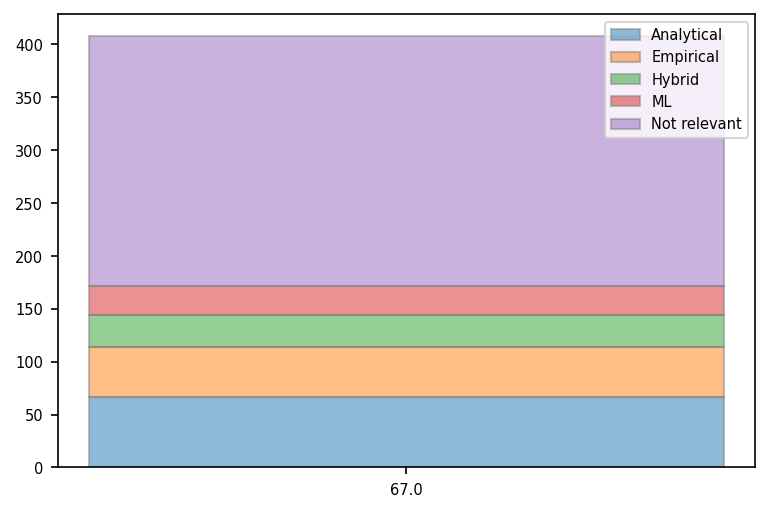

In [14]:
fig, ax = plt.subplots(dpi=150)

Analytical = df.loc[df['seen']==1,'1 - Analytical'].sum()
Empirical = df.loc[df['seen']==1,'1 - Empirical'].sum()
Hybrid = df.loc[df['seen']==1,'1 - Hybrid'].sum()
ML = df.loc[df['seen']==1,'1 - ML'].sum()
overlap = df.loc[df['categories']>=2,].shape[0]
nonrel = df.loc[(df['seen']==1) & (df['categories']==0),].shape[0]

lw = 1
alpha=0.5
ec = "grey"

ax.bar(
    0,Analytical,
    alpha=alpha, label="Analytical",
    lw=lw, edgecolor=ec, tick_label = str(Analytical)
)
ax.bar(
    0,Empirical,bottom=Analytical-overlap/4,
    alpha=alpha, label="Empirical",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,Hybrid,bottom=Analytical-2*overlap/4+Empirical ,
    alpha=alpha, label="Hybrid",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,ML,bottom=Analytical-3*overlap/4+Empirical+Hybrid ,
    alpha=alpha, label="ML",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonrel,bottom=Analytical-overlap+Empirical+Hybrid+ML,
    alpha=alpha, label="Not relevant",
    lw=lw, edgecolor=ec,
)

ax.legend()

In [15]:
classes = ["1 - Analytical","1 - Empirical", "1 - Hybrid","1 - ML"]
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

(6121, 4)


In [16]:
from importlib import reload  
import learning_utils as lu

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)


1


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

2


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

3


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

4


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

5


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

6


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

7


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

8


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

9


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/nu

10


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

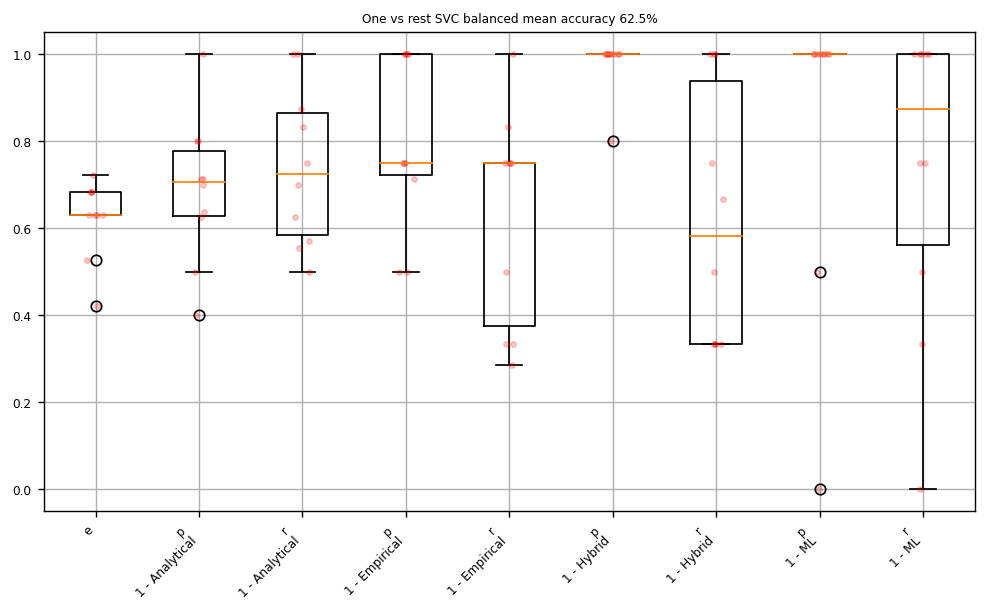

In [17]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


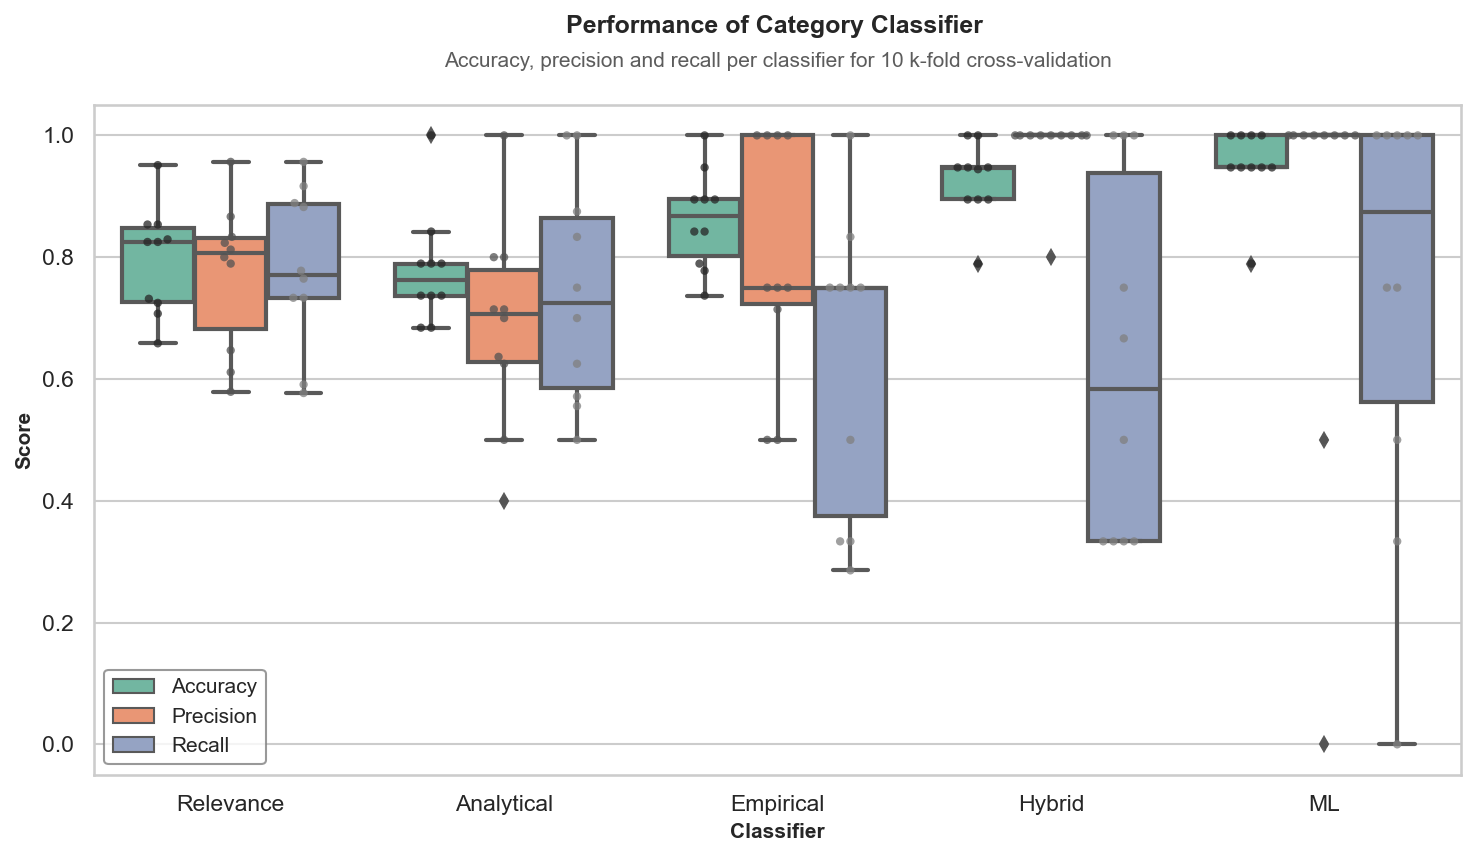

In [18]:
#With better formatting and the overall relevance included in one graph
import seaborn as sns

descriptives = [ #'e', 'p', 'r', 
                'e\n1 - Analytical', 'p\n1 - Analytical', 'r\n1 - Analytical',
                'e\n1 - Empirical', 'p\n1 - Empirical', 'r\n1 - Empirical',
                'e\n1 - Hybrid', 'p\n1 - Hybrid', 'r\n1 - Hybrid',
                'e\n1 - ML', 'p\n1 - ML', 'r\n1 - ML'
               ]

boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[len(models)-1][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index=True).reset_index()

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

#Get the category and the metric separately
new = boxplotdf["Category"].str.split("\n1 - ", n = 1, expand = True)
boxplotdf["Metric"]= new[0]
boxplotdf.drop(columns =["Category"], inplace = True) 
boxplotdf["Category"]= new[1] 

#rename
di = {'e': "Accuracy",
      'p': "Precision",
      'r': "Recall"}
boxplotdf.replace({"Metric": di}, inplace=True)

#plot 
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6),dpi=150)
ax = sns.boxplot(x="Category", y="Scores", hue="Metric",
                 data=boxplotdf, palette="Set2", linewidth = 2)

ax = sns.swarmplot(x="Category", y="Scores", hue="Metric", dodge=True, #add points
                   data=boxplotdf, color="grey", alpha = 0.75, size=4
                  ) 


ax.set_ylabel('Score', fontsize = 10, weight = 'bold')
ax.set_xlabel('Classifier', fontsize = 10, weight = 'bold')

title = 'Performance of Category Classifier '
subtitle = 'Accuracy, precision and recall per classifier for 10 k-fold cross-validation'
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=subtitle, fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
#l = plt.legend()
ax.legend(handles[0:3], labels[0:3],
          fontsize=10, title_fontsize='10', loc = 'lower left',
          facecolor = 'white', edgecolor='grey')


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'{title}_{subtitle}.png')



['1 - Analytical - k_prediction_binary', '1 - Empirical - k_prediction_binary', '1 - Hybrid - k_prediction_binary', '1 - ML - k_prediction_binary']


<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

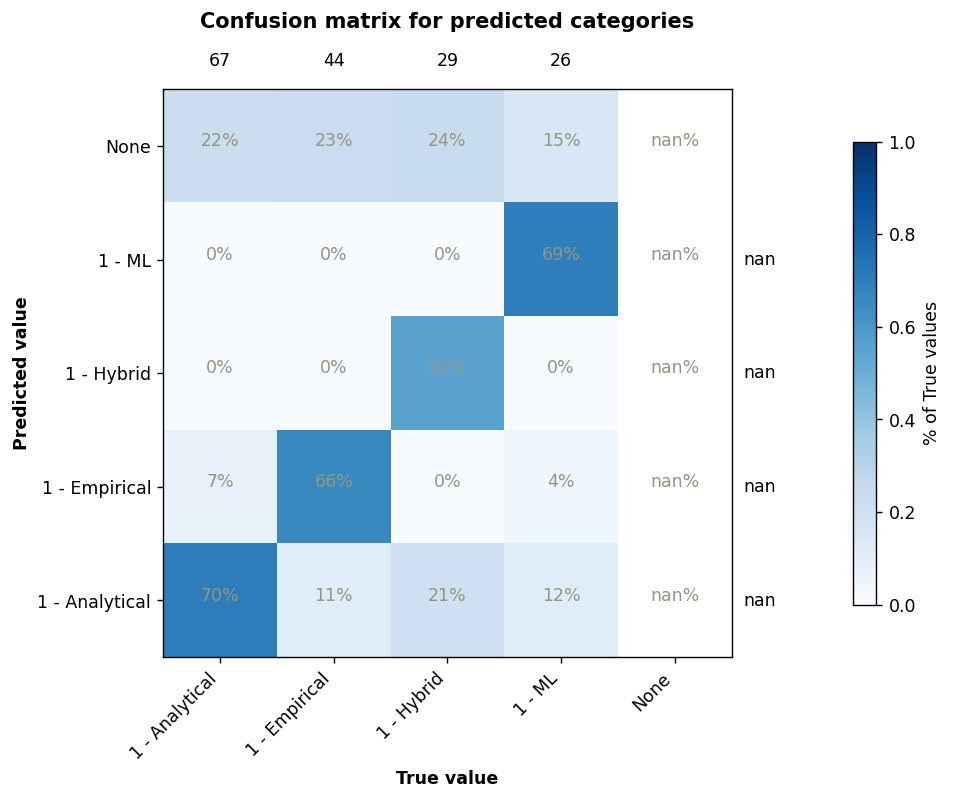

In [19]:
sns.reset_defaults()
classes = ["1 - Analytical","1 - Empirical", "1 - Hybrid","1 - ML"]
cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)
y_pred = np.array(list(df.loc[seen_index,cols].values))
   
y_true = y[seen_index]

confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

norm = True

for j, c in enumerate(classes): #rows
    for k, c in enumerate(classes): #cols
        n = 0
        for i in range(len(seen_index)):
            if j==k:
                if y_true[i,j]+y_pred[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1/y_pred[i,].sum()
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


if norm is not False:
    confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


fig, ax = plt.subplots(dpi=125, figsize=(8,8))


if norm is not False:
    mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1, origin="lower")
else:
    mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")
    
classes = classes + ["None"]
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > np.max(confusion_matrix)/2:
            color="#d9d9d9"
        else:
            color="#949680"
        if norm is not False:
            ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        else:
            ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)

    if j < len(classes)-1:    
        ax.text(j,len(classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center")
        ax.text(len(classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center")
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value", fontsize = 10, weight = 'bold')
ax.set_ylabel("Predicted value", fontsize = 10, weight = 'bold')

#ax.set_xlim(xmax=len(classes)+1)

cbar = fig.colorbar(mat, ax=ax, pad=0.15, shrink = 0.5)
if norm is not False:
    cbar.set_label("% of True values")
    
title = "Confusion matrix for predicted categories"
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'confusion_matrix.png')
fig.show

In [20]:
model_df = pd.DataFrame(multimodels)

predicted_index = df[df['0 - relevance - prediction']>0.4].index
LabeledRelevant_index = df[df['relevant']==1].index

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["1 - Analytical","1 - Empirical", "1 - Hybrid","1 - ML"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index]) #fit on the labeled as relevant data
predictions = clf.predict_proba(ab_X[predicted_index]) #get probability scores for those predicted to be relevant
binary = clf.predict(ab_X[predicted_index]) #get binary scores too

#Add predictions to the dataframe or nan if no prediction
for i,c in enumerate(classes):
    df[f"{c} - prediction"] = np.NaN
    
    df.loc[predicted_index, f"{c} - prediction"] = predictions[:, i]
    
#Check
print(df[df['1 - Analytical - prediction'] > .1].shape)
df[df['1 - Analytical - prediction'] > .1].head(20)

df.to_csv('predFin.csv', index=False)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

(761, 27)


In [21]:
final_relevance = pd.merge(RelevantDocs, df, how="left")
final_relevance.columns
final_relevance.to_csv('RelevantMethodBin.csv', index=False)

In [22]:
final_relevance2 = final_relevance.drop(['PY', 'wosarticle__de', 'wosarticle__wc',
       'relevant', 'seen', 'y_k_prediction', '0 - relevance - prediction', 'categories',
       '1 - Analytical - k_prediction', '1 - Analytical - k_prediction_binary',
       '1 - Empirical - k_prediction', '1 - Empirical - k_prediction_binary',
       '1 - Hybrid - k_prediction', '1 - Hybrid - k_prediction_binary',
       '1 - ML - k_prediction', '1 - ML - k_prediction_binary'], axis=1)



In [23]:
final_relevance2['Method'] = ""

In [24]:
for i in range (0,len(final_relevance2)):
    temparray = [float(final_relevance2['1 - Analytical - prediction'][i]),float(final_relevance2['1 - Empirical - prediction'][i]),float(final_relevance2['1 - Hybrid - prediction'][i]), float(final_relevance2['1 - ML - prediction'][i]) ]
    if max(temparray) == float(final_relevance2['1 - Analytical - prediction'][i]):
                               final_relevance2['Method'][i] = "Analytical"
    if max(temparray) == float(final_relevance2['1 - Empirical - prediction'][i]):
                               final_relevance2['Method'][i] = "Empirical"
    if max(temparray) == float(final_relevance2['1 - Hybrid - prediction'][i]):
                               final_relevance2['Method'][i] = "Hybrid"
    if max(temparray) == float(final_relevance2['1 - ML - prediction'][i]):
                               final_relevance2['Method'][i] = "ML"
    
for i in range (0,len(final_relevance2)):
    if final_relevance2['Method'][i] == "":
        
        temparray = [float(final_relevance2['1 - Analytical'][i]),float(final_relevance2['1 - Empirical'][i]),float(final_relevance2['1 - Hybrid'][i]), float(final_relevance2['1 - ML'][i]) ]
        if max(temparray) == float(final_relevance2['1 - Analytical'][i]):
                                   final_relevance2['Method'][i] = "Analytical"
        if max(temparray) == float(final_relevance2['1 - Empirical'][i]):
                                   final_relevance2['Method'][i] = "Empirical"
        if max(temparray) == float(final_relevance2['1 - Hybrid'][i]):
                                   final_relevance2['Method'][i] = "Hybrid"
        if max(temparray) == float(final_relevance2['1 - ML'][i]):
                                   final_relevance2['Method'][i] = "ML"

C:\Users\User\AppData\Local\Temp\ipykernel_14832\3341541196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_relevance2['Method'][i] = "Analytical"
C:\Users\User\AppData\Local\Temp\ipykernel_14832\3341541196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_relevance2['Method'][i] = "Empirical"
C:\Users\User\AppData\Local\Temp\ipykernel_14832\3341541196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_relevanc

In [25]:
final_relevance2.to_csv('RelevantMethod.csv', index=False)